# Convolutional Neural Network (CNN) from scratch
<em>adapted from Keras_CNN  and Keras_CNN_Tensorboard code</em>

### Import libraries - make sure kernel is Python 3

In [1]:
# IF RUNNING FOR THE FIRST TIME ON AWS
#!pip3 install pillow

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras import backend as K
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#import PIL
from PIL import Image
import pandas as pd
import random
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Set seed

In [4]:
np.random.seed()

### Import data

In [28]:
data = pd.read_csv('id_genre_pairs.csv')
genre_names = data.columns[1:]
print(genre_names)
movie_ids = list(data['movie_id'])
data = np.array(data)


Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Mystery', 'Romance',
       'Science Fiction', 'Thriller', 'War', 'Western'],
      dtype='object')


In [6]:
def convert_data_to_size(width,height):
    ####Convert Data to same size 
    for row in data:
        try:
            img = Image.open('Movie Posters/'+str(row[0])+'.jpg')
            img = img.resize((width,height), PIL.Image.ANTIALIAS)
            img.save('Movie Posters Resized '+str(width)+"x"+str(height)+'/'+str(row[0]) + ".jpg", "JPEG")
        except:
            pass


In [7]:
import os
files = [i for i in os.listdir('Movie Posters Resized 32x32') if i[-3:] == 'jpg']
random.shuffle(files)

training_indices = files[:int(len(files)*0.8)]
test_indices = files[int(len(files)*0.8):]

test = []
test_labels = []
for i in test_indices:
    try:
        img = load_img('Movie Posters Resized 32x32/'+i)
        test.append(img_to_array(img))
        idx = int(i[:i.index(".")])
        for row in data:
            if row[0] == idx:
                test_labels.append(row[1:])
                break
    except:
        pass
    

In [8]:
train = []
train_labels = []
for i in training_indices:
    #try:
    img = load_img('Movie Posters Resized 32x32/'+i)
    train.append(img_to_array(img))
    idx = int(i[:i.index(".")])
    for row in data:
        if row[0] == idx:
            train_labels.append(row[1:])
            break
    #except:
        #pass


### Reshape data to tell Keras there is only one channel

In [9]:
img_rows, img_cols = 32, 32
num_classes = 17

x_train = np.array(train) 
x_test = np.array(test)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

### Normalize images to [0,1]

In [10]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (11757, 32, 32, 3)
x_test shape: (2940, 32, 32, 3)
11757 train samples
2940 test samples


### Create the network structure

In [11]:
import keras.backend as K

# Custom metrics : code adapted from https://github.com/fchollet/keras/issues/5705

def recall_s(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    threshold = 0.1
    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

def precision_s(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    threshold = 0.1
    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [16]:
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout
from keras import regularizers

def accuracy_with_threshold(y_true, y_pred):
    threshold = 0.1
    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())
    return K.mean(K.equal(y_true, y_pred))



In [18]:
# smaller batch size means noisier gradient, but more updates per epoch
#batch_size = 256
batch_size=512 # Just for running locally - change this!
# number of iterations over the complete training data
#epochs = 50
epochs=1 # Just for testing - change this!

In [14]:
precisions = []
recalls = []
f1s = []
parameters = []
model_histories = []
# CV for number of layers, number of dense layers, sgd vs. adam, regularization constant, and learning rate 
for n_conv_layers in [1,2,3]:
    for n_dense_layers in [1,2]:
        for lrate in [0.0005,0.001,0.005,0.01,0.1]:
            for adaptive_change in [0.01,0.05]:
                log_dir_string = "cv"
                log_dir_string += str(lrate)
                log_dir_string += str(adaptive_change)
                K.clear_session()
                model = Sequential()
                model.add(Conv2D(16, kernel_size=(5, 5), 
                                 activation='relu', 
                                 kernel_regularizer=regularizers.l2(0.01),
                                 input_shape=input_shape))
                model.add(Dropout(0.2))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                

                if n_conv_layers == 1:
                    log_dir_string += "_1conv"
                elif n_conv_layers==2:
                    model.add(Conv2D(16, kernel_size=(5, 5), 
                                     activation='relu', 
                                     kernel_regularizer=regularizers.l2(0.01),
                                     input_shape=input_shape))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    log_dir_string += "_2conv"
                else:
                    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    log_dir_string += "_3conv"
                model.add(Flatten())
                model.add(Dense(64, activation='relu'))
                if n_dense_layers == 1:
                    log_dir_string += "_1fc"
                else:
                    model.add(Dense(64, activation='relu'))
                    log_dir_string += "_2fc"

                model.add(Dense(num_classes, activation='sigmoid'))

                #sgd = SGD(lr=0.1, momentum=0.9)
                #model.compile(loss='binary_crossentropy',
                #      optimizer=sgd,
                #      metrics=['accuracy'])
                adam = Adam(lr=lrate)
                #ncce
                model.compile(loss='binary_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy',accuracy_with_threshold, precision_s, recall_s])

                # we need a callback to save information for tensorboard visualizations
                tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

                reduce_lr = ReduceLROnPlateau(monitor='val_accuracy_with_threshold', factor = adaptive_change, patience = 5, min_lr = 0.00001)

                history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test),
                            callbacks=[tensorboard, reduce_lr])



                score = model.evaluate(x_test, y_test, verbose=0)
                predictions = (model.predict(x_test)>0.1).astype(int)
                print(n_conv_layers, n_dense_layers, lrate, adaptive_change)
                parameters.append([n_conv_layers, n_dense_layers, lrate, adaptive_change])
    
                model_histories.append(history)
                precision = precision_score(y_test, predictions, average="micro")
                recall = recall_score(y_test, predictions, average="micro")
                f1 = f1_score(y_test, predictions, average="micro")
                recalls.append(recall)
                precisions.append(precision)
                f1s.append(f1)
                
                print('Test loss:', score[0])
                print('Test accuracy:', score[1])
                print("Precision: ", precision, "micro, ", precision_score(y_test, predictions, average="macro"), " macro", )
                print("Recall: ", recall, "micro, ", recall_score(y_test, predictions, average="macro"), "macro ") 
                print("F1-score:", f1_score(y_test, predictions, average="micro"), "micro, ", f1_score(y_test, predictions, average="macro"), "macro")
            

                 

INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
1 1 0.0005
Test loss: 0.326033651504
Test accuracy: 0.916266491137
Precision:  0.138658902739 micro,  0.0935174001193  macro
Recall:  0.729535662997 micro,  0.452617149618 macro 
F1-score: 0.233027522936 micro,  0.143315222751 macro
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illega

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
1 1 0.01
Test loss: 0.286013820909
Test accuracy: 0.91640654632
Precision:  0.174623539739 micro,  0.0862816452922  macro
Recall:  0.618956438487 micro,  0.307719110499 macro 
F1-score: 0.272396903144 micro,  0.130977342769 macro
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; 

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
1 1 0.1
Test loss: 1.36635397875
Test accuracy: 0.91640654632
Precision:  0.0 micro,  0.0  macro
Recall:  0.0 micro,  0.0 macro 
F1-score: 0.0 micro,  0.0 macro
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/

In [21]:
max_index = np.array(f1s).argmax()
print("Best performance", max_index)
parameters[max_index]

Best performance 27


[2, 1, 0.01]

In [51]:
batch_size=256 
epochs=20
n_conv_layers = 1 #parameters[max_index][0]
n_dense_layers = 1 #parameters[max_index][1]
lrate = 0.001 #parameters[max_index][2]
adaptive_change = 0.01

log_dir_string = "cv"
log_dir_string += str(lrate)
log_dir_string += str(adaptive_change)
K.clear_session()
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), 
                 activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01),
                 input_shape=input_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))


if n_conv_layers == 1:
    log_dir_string += "_1conv"
elif n_conv_layers==2:
    model.add(Conv2D(16, kernel_size=(5, 5), 
                     activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01),
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    log_dir_string += "_2conv"
else:
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    log_dir_string += "_3conv"
model.add(Flatten())
model.add(Dense(64, activation='relu'))
if n_dense_layers == 1:
    log_dir_string += "_1fc"
else:
    model.add(Dense(64, activation='relu'))
    log_dir_string += "_2fc"

model.add(Dense(num_classes, activation='sigmoid'))

adam = Adam(lr=lrate)
#ncce
model.compile(loss='binary_crossentropy',
      optimizer=adam,
      metrics=['accuracy',accuracy_with_threshold, precision_s, recall_s])

# we need a callback to save information for tensorboard visualizations
tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy_with_threshold', factor = adaptive_change, patience = 5, min_lr = 0.00001)

history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard, reduce_lr])



score = model.evaluate(x_test, y_test, verbose=0)
predictions = (model.predict(x_test)>0.1).astype(int)
print(n_conv_layers, n_dense_layers, lrate, adaptive_change)

precision = precision_score(y_test, predictions, average="micro")
recall = recall_score(y_test, predictions, average="micro")
f1 = f1_score(y_test, predictions, average="micro")

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Precision: ", precision, "micro, ", precision_score(y_test, predictions, average="macro"), " macro", )
print("Recall: ", recall, "micro, ", recall_score(y_test, predictions, average="macro"), "macro ") 
print("F1-score:", f1_score(y_test, predictions, average="micro"), "micro, ", f1_score(y_test, predictions, average="macro"), "macro")


                 

Train on 11757 samples, validate on 2940 samples
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
Epoch 1/20
11757/11757 [==============================] - 22s - loss: 0.3309 - acc: 0.9044 - accuracy_with_threshold: 0.6712 - precision_s: 0.1684 - recall_s: 0.6443 - val_loss: 0.2941 - val_acc: 0.9160 - val_accuracy_with_threshold: 0.6555 - val_precision_s: 0.1562 - val_recall_s: 0.7037
Epoch 2/20
11757/11757 [==============================] - 28s - loss: 0.2771 - acc: 0.9173 - accuracy_with_threshold: 0.7781 - pr

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
from matplotlib.pyplot import imshow
probabilities = model.predict(x_test)

Action : Top 5 most representative posters


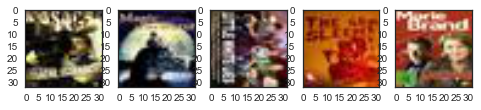

Adventure : Top 5 most representative posters


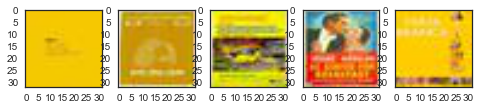

Animation : Top 5 most representative posters


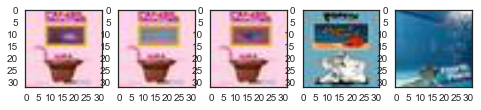

Comedy : Top 5 most representative posters


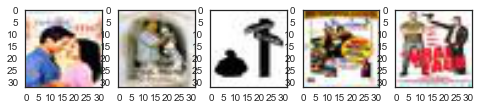

Crime : Top 5 most representative posters


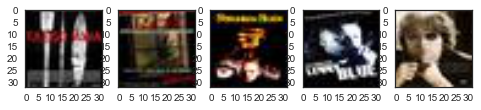

Documentary : Top 5 most representative posters


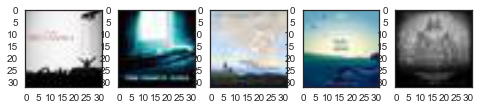

Drama : Top 5 most representative posters


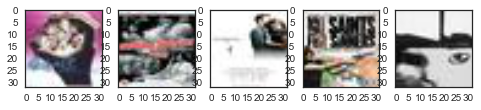

Family : Top 5 most representative posters


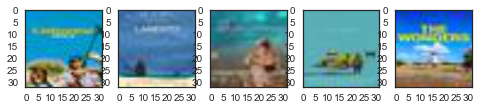

Fantasy : Top 5 most representative posters


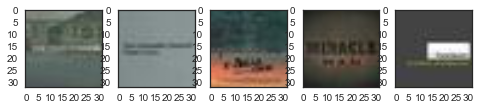

History : Top 5 most representative posters


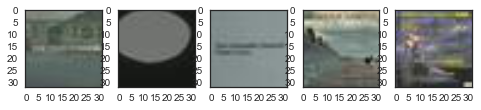

Horror : Top 5 most representative posters


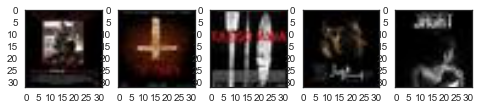

Mystery : Top 5 most representative posters


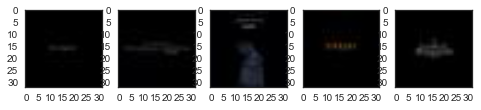

Romance : Top 5 most representative posters


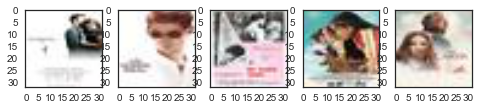

Science Fiction : Top 5 most representative posters


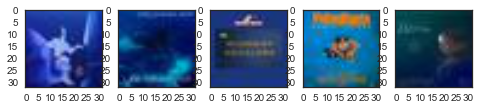

Thriller : Top 5 most representative posters


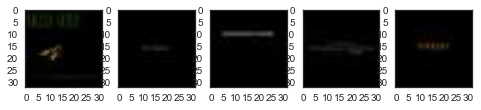

War : Top 5 most representative posters


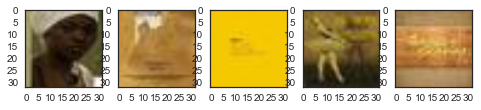

Western : Top 5 most representative posters


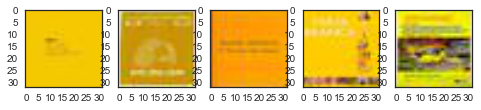

In [57]:
for genre in range(len(genre_names)):
    print(genre_names[genre], ": Top 5 most representative posters")
    top_indices = probabilities[:,genre].argsort()[-5:][::-1]
    #print(top_indices)
    for index in range(len(top_indices)):
        image_fname = test_indices[top_indices[index]]
        plt.subplot(1, len(top_indices),index+1)
        pil_im = Image.open('Movie Posters Resized 32x32/'+image_fname, 'r')
        plt.imshow(np.asarray(pil_im))
    plt.show()

### Visualize accuracy as a function of training epoch

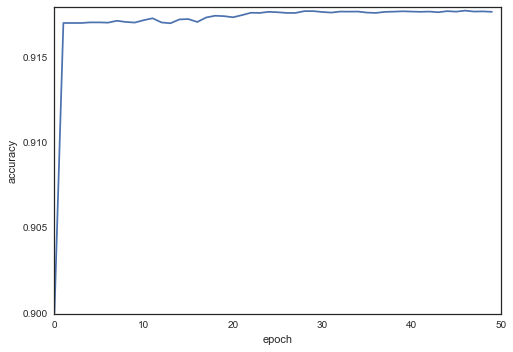

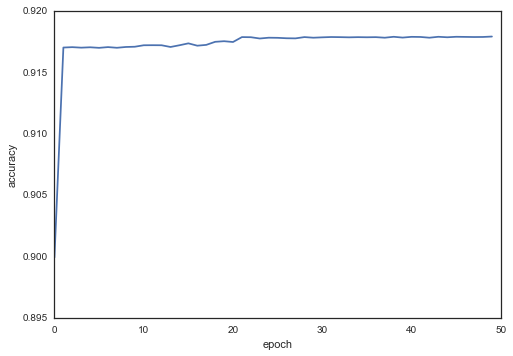

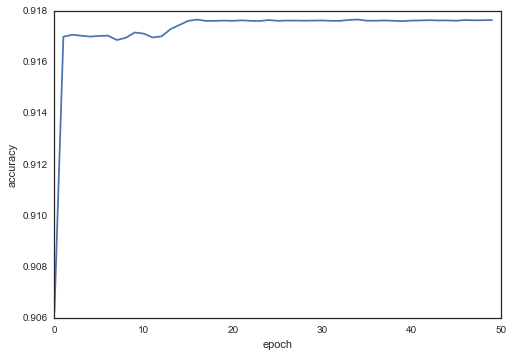

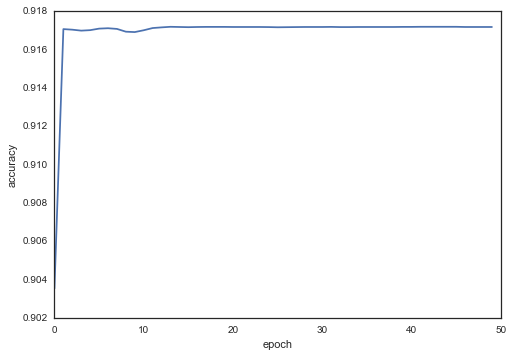

In [80]:
#here is a visualization of the training process
#typically we gain a lot in the beginning and then
#training slows down
for history in model_histories:
   plt.plot(history.history['acc'])
   plt.xlabel("epoch")
   plt.ylabel("accuracy")
   plt.show()

### Get the weights from the first layer and visualize

Shape of W
(5, 5, 3, 16)


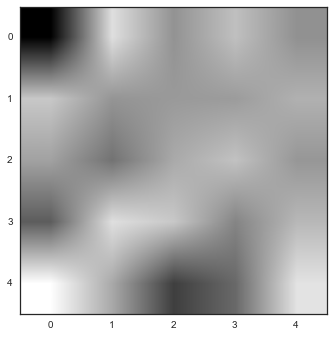

In [81]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray')

### Visualize the weights from the first 25 filters

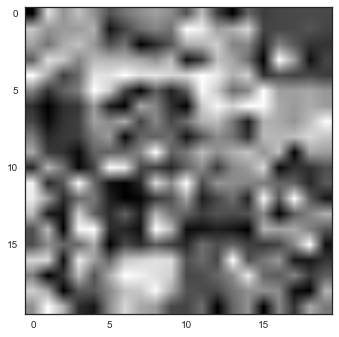

In [82]:
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()



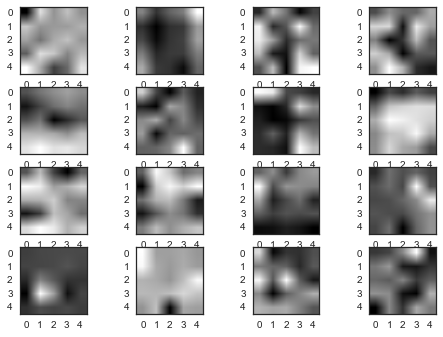

In [83]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()